# Setup

This requires fastai V1

In [ ]:
!pip install fastai==1.0.61

In [5]:
!pip install torch==1.4.0
!pip install torchvision==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1
    Uninstalling torchvision-0.14.1:
      Successfully uninstalled torchvision-0.14.1


## Dependencies

In [2]:
from os import path
import os
import shutil
import glob

## Prepare Dataset

In [3]:
# Get paths
raw_data_path = path.join(os.getcwd(), "rawdata")
temp_data_path = path.join(os.getcwd(), "tempdata")
data_path = path.join(os.getcwd(), "data")
train_path = path.join(data_path, "train")
test_path = path.join(data_path, "test")

In [4]:
# Randomly copy 20% of each class from rawdata into test and the rest into train
import random

def generate_train_test_folder(labels_filter=["Covid-19", "No_findings"], clean=False):
    if clean:
        # Remove old data and tempdata folders, create new data folder
        for _path in [temp_data_path, data_path]:
            shutil.rmtree(_path, ignore_errors=True)
    
    # Create temp data folder
    shutil.copytree(raw_data_path, temp_data_path)
    
    # Create data folder
    os.mkdir(data_path)
    os.mkdir(train_path)
    os.mkdir(test_path)

    test_size = 0.2
    labels = os.listdir(temp_data_path)
    

    for label in labels:
        if label not in labels_filter:
            continue
        count = 0
        images = os.listdir(path.join(temp_data_path, label))
        num_test = int(len(images) * 0.2)
        os.mkdir(path.join(test_path, label))
        os.mkdir(path.join(train_path, label))
        while num_test > 0:
            # get a random image
            image = images.pop(random.randrange(len(images)))
            os.rename(path.join(temp_data_path, label, image), path.join(test_path, label, image))
            num_test -= 1
            count+=1
        print(f"Test for {label}: {count}")
        for file in glob.glob(path.join(temp_data_path, label, "*")):
            count+=1
            os.rename(file, path.join(train_path, label, path.basename(file)))
        print(f"Total for {label}: {count}")
    
    # Remove temp folder
    shutil.rmtree(temp_data_path)
            
generate_train_test_folder(clean=True)

Test for Covid-19: 25
Total for Covid-19: 125
Test for No_findings: 100
Total for No_findings: 500


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *
import fastai

### Data

In [7]:
np.random.seed(41)
data = ImageDataBunch.from_folder(data_path, train="train", valid ="test",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [9]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 500
Number of examples in validation: 125


In [10]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

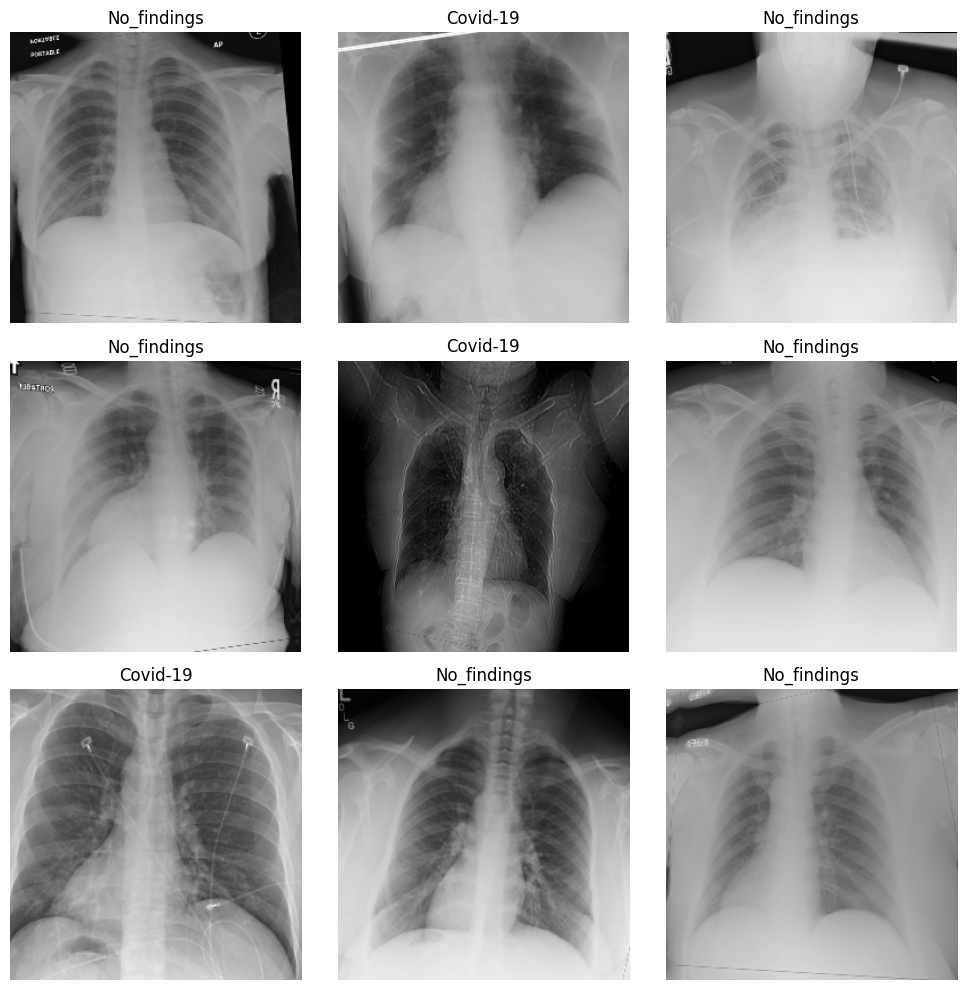

In [11]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [44]:
model = nn.Sequential(
    # Conv block 1
    conv_block(3, 8),
    maxpooling(),
    
    # Conv block 2
    conv_block(8, 16),
    maxpooling(),
    
    # Triple conv 1
    triple_conv(16, 32),
    maxpooling(),
    
    # Triple conv 2
    triple_conv(32, 64),
    maxpooling(),
    
    # Triple conv 3
    triple_conv(64, 128),
    maxpooling(),
    
    # Triple conv 4
    triple_conv(128, 256),
    
    # Conv block 3
    conv_block(256, 128, size=1),
    
    # Conv block 4
    conv_block(128, 256),
    
    # Conv Layer 1
    conv_layer(256, 2),
    
    # Dense
    Flatten(),
    nn.Linear(338, 2)
)

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [31]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [32]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [18]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.349020,0.685783,0.800000,00:38
1,0.270253,0.633986,0.856000,00:39
2,0.224515,0.162306,0.952000,00:43
3,0.188267,0.208503,0.904000,00:36
4,0.186629,0.119723,0.952000,00:41
5,0.168936,0.106672,0.968000,00:44
6,0.159219,0.092046,0.968000,00:38
7,0.147157,0.090795,0.976000,00:41
8,0.148425,0.051728,0.984000,00:43
9,0.139612,0.333164,0.888000,00:40


In [41]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [19]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [20]:
accuracy(probs,targets)

tensor(0.9920)

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [22]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
_accuracy = correct / len(probs)
print(len(probs), correct, _accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 124 0.992
[[ 24   1]
 [  0 100]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.96      0.98        25
 No_findings       0.99      1.00      1.00       100

    accuracy                           0.99       125
   macro avg       1.00      0.98      0.99       125
weighted avg       0.99      0.99      0.99       125



In [23]:
interp = ClassificationInterpretation.from_learner(learn)

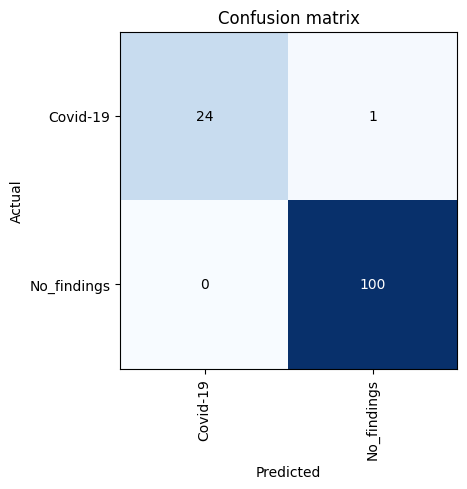

In [24]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);